<a href="https://colab.research.google.com/github/CarlViggo/Carl-Viggo---Rays-2023/blob/main/Rays%2C_DL_Project%2C_Carl_Viggo_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Pipeline
The following code classifies images of lung tumors from the Kaggle Data Science Bowl 2017 data set. The datasets are initially balanced using a General Adversarial Neural Network. 

**Part 1** \\
Random Forests, Decision Tree and K-Nearest Neighbors are initially compared to one another. The best model is chosen and evaluated furter. The code for Part 1 is in-house software and therefore not publically availible. 

**Part 2** \\
Dataset is balanced using GAN technology. A pretrained InceptionV3 and a VGG16 are fine-tuned and evaluated. 

Contributor: Carl Viggo Nilsson Gravenhorst-Lövenstierne. carlviggo@icloud.com

**The following definitions are used in the code**
\
\
1 - Malignant \\
0 - Benign
\
\
Class1 - benign \\
Class2 - malignant
\
\
Train size = 907 \\
Validation size = 390

---

In [2]:
pip install scikit-image


  Using cached scipy-1.11.4-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
   ---------------------------------------- 0.0/25.0 MB ? eta -:--:--
    --------------------------------------- 0.3/25.0 MB 10.2 MB/s eta 0:00:03
    --------------------------------------- 0.6/25.0 MB 9.7 MB/s eta 0:00:03
    --------------------------------------- 0.6/25.0 MB 9.7 MB/s eta 0:00:03
    --------------------------------------- 0.6/25.0 MB 9.7 MB/s eta 0:00:03
   - -------------------------------------- 0.9/25.0 MB 4.0 MB/s eta 0:00:06
   - -------------------------------------- 1.2/25.0 MB 4.4 MB/s eta 0:00:06
   -- ------------------------------------- 1.5/25.0 MB 4.9 MB/s eta 0:00:05
   -- ------------------------------------- 1.8/25.0 MB 5.0 MB/s eta 0:00:05
   --- ------------------------------------ 2.1/25.0 MB 5.3 MB/s eta 0:00:05
   --- ------------------------------------ 2.1/25.0 MB 5.3 MB/s eta 0:00:05
   --- ----------------


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import cv2
import numpy as np
from random import shuffle
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.transform import resize
import pickle

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, ZeroPadding2D, Reshape, LeakyReLU, UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Convolution2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from tensorflow.keras import applications


In [3]:
seed_value = 42 #... Sorry
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

Functions to combine data with labels

In [4]:
#Matches the file name with its corresponding class
def gen_labels(im_name, data_path, pat1, pat2):
    '''

    Parameters
    ----------
    im_name : Str
        The image file name.

    Returns
    -------
    Label : Numpy array
        Class label of the filename name based on its pattern.
    '''
    if "C1" in data_path:
        label = np.array([0])
    elif "C2" or "Malignant" in data_path:
        label = np.array([1])
    return label

#Creates a nested list with the following structure: [(file_name, label), ...]
def get_data(data_path, data_list, img_h, img_w):
    """

    Parameters
    ----------
    train_data_path : Str
        Path to the data directory
    train_list : List
        A list containing the name of the images.
    img_h : Int
        image height to be resized to.
    img_w : Int
        image width to be resized to.
    """
    img_labels = []
    for item in enumerate(data_list):
        img = imread(os.path.join(data_path, item[1]), as_gray = False) # "as_grey"
        #img = cv2.imread(os.path.join(data_path, item[1]))
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        img_labels.append([np.array(img), gen_labels(item[1], data_path,  'AFF', 'NFF')])

        if item[0] % 100 == 0:
             print('Reading: {0}/{1}  of train images'.format(item[0], len(data_list)))

    #Shuffles the list for generalization purposes
    shuffle(img_labels)
    return img_labels

#Unfolds the images and converts them to compatible arrays.
def get_data_arrays(nested_list, img_h, img_w):
    """
    Parameters
    ----------
    nested_list : nested list
        nested list of image arrays with corresponding class labels.
    img_h : Int
        Image height.
    img_w : Int
        Image width.

    Returns
    -------
    img_arrays : Numpy array
        4D Array with the size of (n_data,img_h,img_w, 1)
    label_arrays : Numpy array
        1D array with the size (n_data).

    """
    img_arrays = np.zeros((len(nested_list), img_h, img_w), dtype = np.float32)
    label_arrays = np.zeros((len(nested_list)), dtype = np.int32)
    for ind in range(len(nested_list)):
        img_arrays[ind] = nested_list[ind][0]
        label_arrays[ind] = nested_list[ind][1]
    img_arrays = np.expand_dims(img_arrays, axis =3)
    return img_arrays, label_arrays

#Returns the training and the testing data
def get_train_test_arrays(train_data_path, test_data_path, train_list,
                          test_list, img_h, img_w):

    """
    Get the directory to the train and test sets, the files names and
    the size of the image and return the image and label arrays for
    train and test sets.
    """

    train_data = get_data(train_data_path, train_list, img_h, img_w)
    test_data = get_data(test_data_path, test_list, img_h, img_w)

    train_img, train_label =  get_data_arrays(train_data, img_h, img_w)
    test_img, test_label = get_data_arrays(test_data, img_h, img_w)
    del(train_data)
    del(test_data)
    return train_img, test_img, train_label, test_label

In [5]:
#Define input arguments for get_train_test_arrays

c1_train_data_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\images\\class1\\C1_train"
c1_test_data_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\images\\class1\\C1_test"

c2_train_data_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\images\class2\\C2_train"
c2_test_data_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\images\class2\\C2_test"

#Creates lists containing the file names for the different classes
c1_train_list = os.listdir(c1_train_data_path)
c1_val_list = os.listdir(c1_test_data_path)

c2_train_list = os.listdir(c2_train_data_path)
c2_val_list = os.listdir(c2_test_data_path)

In [6]:
#Defines the image dimensions
img_h = 224
img_w = 224

In [7]:
#Retrieves training and testing data for C1 class (benign)
c1_x_train, c1_x_test, c1_y_train, c1_y_test = get_train_test_arrays(c1_train_data_path, c1_test_data_path, c1_train_list, c1_val_list, img_h, img_w)


Reading: 0/748  of train images


Reading: 100/748  of train images
Reading: 200/748  of train images
Reading: 300/748  of train images
Reading: 400/748  of train images
Reading: 500/748  of train images
Reading: 600/748  of train images
Reading: 700/748  of train images
Reading: 0/120  of train images
Reading: 100/120  of train images


In [10]:
#Retrieves training and testing data for C2 class (malignant)
c2_x_train, c2_x_test, c2_y_train, c2_y_test = get_train_test_arrays(
        c2_train_data_path, c2_test_data_path,
        c2_train_list, c2_val_list, img_h, img_w)

Reading: 0/293  of train images
Reading: 100/293  of train images
Reading: 200/293  of train images
Reading: 0/120  of train images
Reading: 100/120  of train images


In [11]:
print(len(c1_x_test))
print(len(c2_x_test))


120
120


In [12]:
#Combines the C1 and the C2 testing and training data to create the final training and testing data
#x_.... are lists containing image arrays
#y_... containt labels, either 0 or 1 for the corresponding images 
x_train = np.concatenate((c1_x_train, c2_x_train))
y_train = np.concatenate((c1_y_train, c2_y_train))
x_val = np.concatenate((c1_x_test, c2_x_test))
y_val = np.concatenate((c1_y_test, c2_y_test))

x_train.shape
y_train.shape

(1041,)

View data-samples


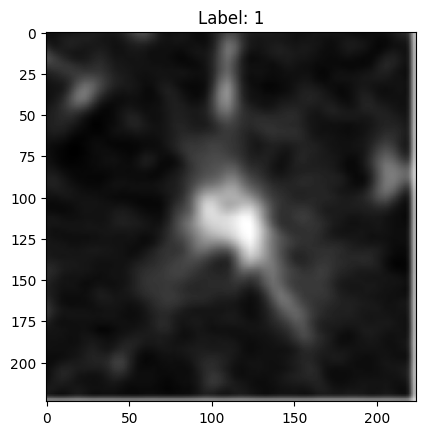

In [13]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(x_train))
plt.imshow(x_train[idx], cmap='gray')
plt.title(f"Label: {y_train[idx]}")
plt.show()

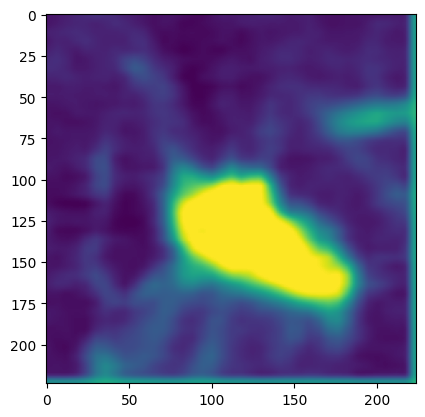

In [14]:
#Verify matching between image and label.
plt.imshow(x_train[100])


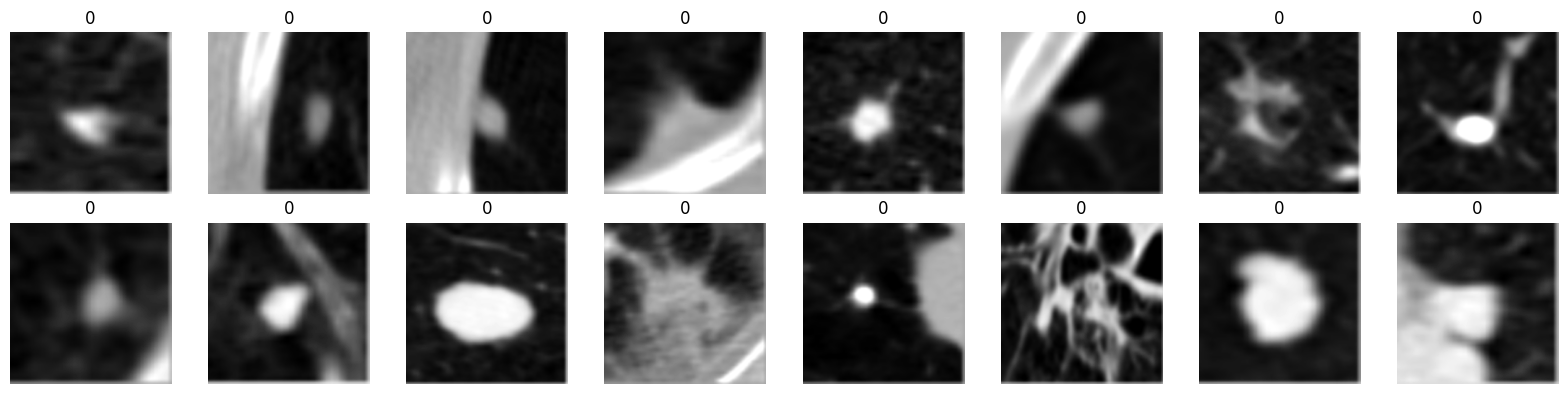

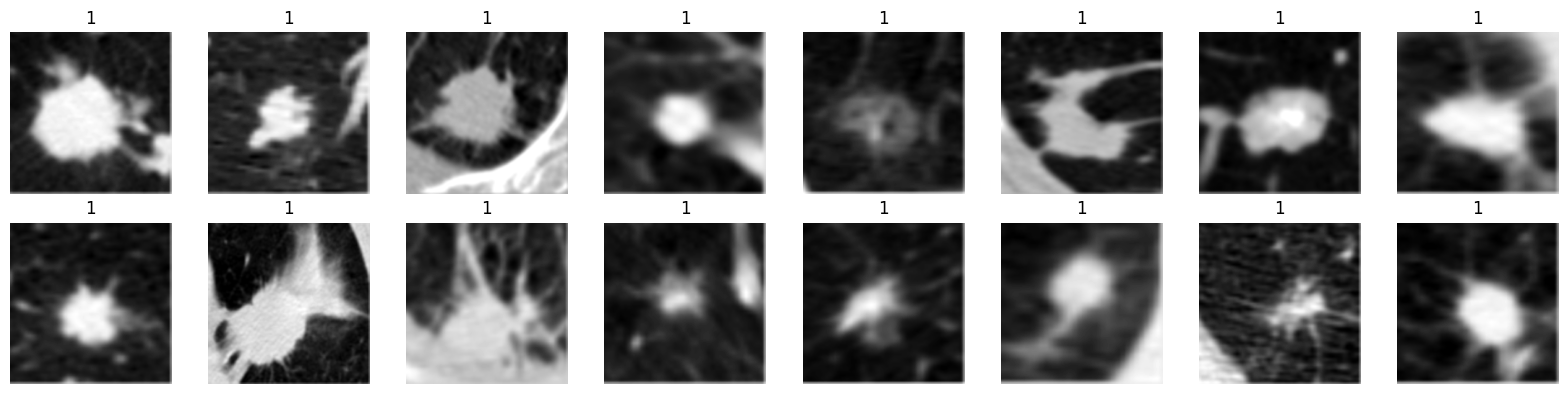

In [15]:
#For vizualisation purposes. Vizualizez a selection of images from the both classes and their corresponding labels

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 8, figsize=(16, 4))

# Array of titles
titles = y_train

# Iterate over each subplot and title
for i in range(2):
    for j in range(8):
        # Load and display the images
        axs[i, j].imshow(x_train[i*8 + j], cmap='gray')
        axs[i, j].set_title(titles[i*8 + j])
        axs[i, j].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

fig2, axs2 = plt.subplots(2, 8, figsize=(16, 4))

# Starting index
start_index = 890

# Repeat for second class
for k in range(2):
    for h in range(8):
        index = start_index + k*8 + h

        axs2[k, h].imshow(x_train[index], cmap='gray')

        axs2[k, h].set_title(y_train[index])

        axs2[k, h].axis('off')

plt.tight_layout()

plt.show()

# Balance datasets using Convolutional Generative Adversarial Network (DCGAN) 


In [290]:
# Training parameters
EPOCHS = 200
BATCH_SIZE = 32


Define GAN Architecture

In [101]:
from tensorflow.keras import layers, models
import tensorflow as tf
import time

# Generator model for generating 224x224x1 images
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 224, 224, 1)
    return model

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(224, 224, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# Create the models
generator = build_generator()
discriminator = build_discriminator()

# Loss functions
def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Learning rate schedules
generator_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
discriminator_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=generator_lr_schedule)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=discriminator_lr_schedule)

@tf.function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        # Print the shape of generated images for debugging
        print("Generated Images Shape:", generated_images.shape)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Debugging: Print the gradients
    print("Gradients of Generator:", gradients_of_generator)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


    return gen_loss, disc_loss

# Generate Images of Malignant Tumors



In [102]:
#Generate high resolution data of the malignant class.
malignant_hr_train, malignant_hr_test, skip, skip = get_train_test_arrays(c2_train_data_path, c2_test_data_path, c2_train_list, c2_val_list, 224, 224)


Reading: 0/293  of train images
Reading: 100/293  of train images
Reading: 200/293  of train images
Reading: 0/120  of train images
Reading: 100/120  of train images


In [103]:
# Load and preprocess dataset
malignant_data = np.concatenate((malignant_hr_train, malignant_hr_test))

dataset_mal = tf.data.Dataset.from_tensor_slices(malignant_data)

# Set batch size
batched_dataset_mal = dataset_mal.batch(BATCH_SIZE)

# list to store loss-values
discriminator_losses = []

Training-loop for the GAN 

In [105]:
import cv2
import numpy as np
import time

# Define the file path where you want to save the images
prog_im_file_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\TrainingProgression"
prog_gen_file_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\GeneratorProgression"

# Training loop for malignant testing data
for epoch in range(EPOCHS):
    start_time = time.time()
    gen_loss_list = []
    disc_loss_list = []

    # Replace 'batched_dataset_mal' with your actual dataset
    for image_batch in batched_dataset_mal:  
        gen_loss, disc_loss = train_step(image_batch)
        gen_loss_list.append(gen_loss.numpy())
        disc_loss_list.append(disc_loss.numpy())

    epoch_gen_loss = np.mean(gen_loss_list)
    epoch_disc_loss = np.mean(disc_loss_list)
    end_time = time.time()

    print(f"Epoch {epoch}, Generator Loss: {epoch_gen_loss}, Discriminator Loss: {epoch_disc_loss}, Time: {end_time - start_time}s")

    if (epoch + 1) % 5 == 0:
        noise = tf.random.normal([1, 100])
        generated_image = generator(noise, training=False)
        generated_image_array = (generated_image[0].numpy() + 1) * 127.5
        cv2.imwrite(f"{prog_im_file_path}/generated_image_epoch_{epoch+1}.png", generated_image_array)
        generator.save(f"{prog_gen_file_path}/generator_epoch_{epoch+1}.h5")


        end_time = time.time()  # End the timer for the epoch
        epoch_time = end_time - start_time  # Calculate the time for the epoch

        print(f"Epoch {epoch} took {epoch_time:.2f} seconds")

        if (epoch + 1) % 5 == 0:
            noise = tf.random.normal([1, 100])
            generated_image2 = generator(noise, training=False)
            generated_image2_array = (generated_image2[0].numpy() + 1) * 127.5  # Scale the image

            # Save the image using OpenCV
            cv2.imwrite(f"{prog_im_file_path}\\VERSION4generated_image_epoch_{epoch+1}.png", generated_image2_array)

            # Save the generator model
            generator.save(f"{prog_gen_file_path}\\VERSION4Advanced_generator_malignant_epoch_{epoch+1}.h5")


Epoch 0, Generator Loss: 5.58024787902832, Discriminator Loss: 0.014133863151073456, Time: 35.91033720970154s
Epoch 1, Generator Loss: 5.4859538078308105, Discriminator Loss: 0.012188665568828583, Time: 34.44158601760864s
Epoch 2, Generator Loss: 6.664101600646973, Discriminator Loss: 0.007376695517450571, Time: 36.59707450866699s
Epoch 3, Generator Loss: 6.762569427490234, Discriminator Loss: 0.002400308148935437, Time: 34.42952489852905s
Epoch 4, Generator Loss: 6.6297760009765625, Discriminator Loss: 0.002770456951111555, Time: 35.033061504364014s
Epoch 4 took 35.12 seconds


c:\Users\Johan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 5, Generator Loss: 7.208052158355713, Discriminator Loss: 0.0021532587707042694, Time: 35.13840341567993s
Epoch 6, Generator Loss: 8.255663871765137, Discriminator Loss: 0.0011803200468420982, Time: 35.977949380874634s
Epoch 7, Generator Loss: 8.304198265075684, Discriminator Loss: 0.0008793065208010375, Time: 36.66870093345642s
Epoch 8, Generator Loss: 8.315396308898926, Discriminator Loss: 0.0005963791045360267, Time: 35.19778347015381s
Epoch 9, Generator Loss: 8.26314926147461, Discriminator Loss: 0.000556528742890805, Time: 30.392332792282104s
Epoch 9 took 30.46 seconds
Epoch 10, Generator Loss: 8.45771598815918, Discriminator Loss: 0.000697293144185096, Time: 30.678070306777954s
Epoch 11, Generator Loss: 8.518705368041992, Discriminator Loss: 0.0004943767562508583, Time: 31.784008026123047s
Epoch 12, Generator Loss: 9.093117713928223, Discriminator Loss: 0.0003285527927801013, Time: 33.49599289894104s
Epoch 13, Generator Loss: 9.251025199890137, Discriminator Loss: 0.0002518

Visualise Training Progression of the GAN Network


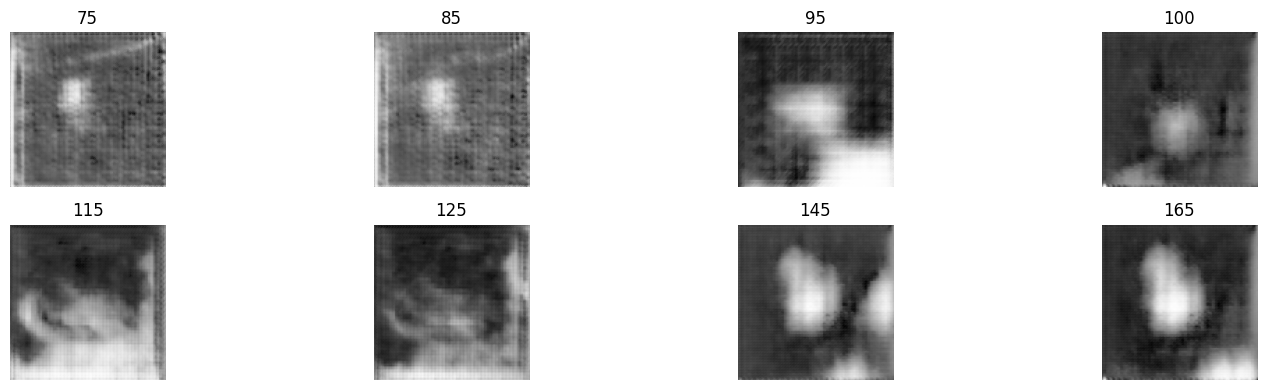

In [6]:
import matplotlib.pyplot as plt
import os
from PIL import Image

#image_dir = r'C:\Users\Johan\Documents\GY-Projekt\TrainingProgression\Display_in_report'
image_dir = "C:\\Users\\Johan\Documents\\GY-Projekt\GeneratedImages\\Benign\\Generated_Benign"

image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

# sort the image files based on the numeric part of the filename
image_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))


fig, axs = plt.subplots(2, 4, figsize=(16, 4))

# iterate over the sorted image files
for i in range(8):
    # load and display the images
    image_path = os.path.join(image_dir, image_files[i])
    img = Image.open(image_path)
    # remove ".png"  from the file name
    title = os.path.splitext(image_files[i])[0]
    axs[i // 4, i % 4].imshow(img, cmap='gray')  # Updated for a 2x4 grid
    axs[i // 4, i % 4].set_title(title)  # Updated for a 2x4 grid
    axs[i // 4, i % 4].axis('off')  # Updated for a 2x4 grid

# Adjust the spacing between subplots
plt.tight_layout()
output_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\Fotografier\\GeneratorProgressionHighResNYYY.png"
plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1, format='png', dpi=300)

plt.show()

# Create Balanced Training and Testing Data


In [26]:
# Save the generator model for later use
generator.save('C:\\Users\\Johan\\Documents\\GY-Projekt\\FINAL_GEN_W_LOSS(notused).h5')

Generate Malignant Training Images



In [130]:
import os
import numpy as np
import tensorflow as tf 
from tensorflow import keras
# Get the current working directory
generator = keras.models.load_model('C:\\Users\\Johan\\Documents\\GY-Projekt\\GeneratorProgression\\VERSION4Advanced_generator_malignant_epoch_135.h5')

save_directory = "C:\\Users\\Johan\\Documents\\GY-Projekt\\GeneratedImages\\Malignant\\Improved_version"
num_images = 455

for i in range(num_images): 
    # random noise vector
    noise = np.random.normal(0, 1, size=(1, 100))  # You can adjust the size as needed

    # generate image
    generated_image_benign = generator.predict(noise)

    filename = 'V4Malignant_test_ep100_bs6_{nr}.png'.format(nr=str(i))

    full_path = os.path.join(save_directory, filename)
    tf.keras.preprocessing.image.save_img(full_path, generated_image_benign[0])

1/1 [==============================] - 0s 20ms/step


Retrieve the Synthetizised Images


In [182]:
#Define input arguments for get_train_test_arrays (this line irrelevant)
c2_test_data_path_gen = "C:\\Users\\Johan\\Documents\\GY-Projekt\\GeneratedImages\\Malignant\\Improved_Version_test"
#This is the path to the directory with the new 
c2_train_data_path_gen = "C:\\Users\\Johan\\Documents\\GY-Projekt\\GeneratedImages\\Malignant\\Improved_version"

c2_test_list_gen = os.listdir(c2_test_data_path_gen)
c2_train_list_gen = os.listdir(c2_train_data_path_gen)


#Retrieves training and testing data for C2 class (malignant)
malignant_x_train, malignant_x_test, malignant_y_train, malignant_y_test = get_train_test_arrays(
        c2_train_data_path_gen, c2_test_data_path_gen,
        c2_train_list_gen, c2_test_list_gen, img_h, img_w)

Reading: 0/455  of train images
Reading: 100/455  of train images
Reading: 200/455  of train images
Reading: 300/455  of train images
Reading: 400/455  of train images


In [183]:
len(c2_train_list_gen)

455

In [184]:
#The variables of interest are generated_malignant_x and malignant_labels, these are inserted to create the training data for the models further down. 
x_train = np.concatenate((c1_x_train, c2_x_train, malignant_x_train))
y_train = np.concatenate((c1_y_train, c2_y_train, malignant_y_train))
x_val = np.concatenate((c1_x_test, c2_x_test))
y_val = np.concatenate((c1_y_test, c2_y_test))

In [185]:
count_zeros = np.count_nonzero(y_train == 0)
count_ones = np.count_nonzero(y_train == 1)
print("Number of 0s in the training array:", count_zeros)
print("Number of 1s in the training array:", count_ones)
count_zeros = np.count_nonzero(y_val == 0)
count_ones = np.count_nonzero(y_val == 1)
print("Number of 0s in the testing array:", count_zeros)
print("Number of 1s in the testing array:", count_ones)

Number of 0s in the training array: 748
Number of 1s in the training array: 748
Number of 0s in the testing array: 120
Number of 1s in the testing array: 120


In [186]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [187]:
x_train.shape

(1496, 224, 224, 1)

# Plotting Function

In [91]:
#Generates two subplots of learning curves
def plotting(model_name, directory_path, save, from_val, from_acc):

  model_std_loss = np.std(model_name.history["val_loss"][from_val:])
  model_mean_loss = np.mean(model_name.history["val_loss"][from_val:])
  model_boundary_high_loss = model_mean_loss + model_std_loss
  model_boundary_low_loss = model_mean_loss - model_std_loss

  model_std_acc = np.std(model_name.history["val_binary_accuracy"][from_acc:])
  model_mean_acc = np.mean(model_name.history["val_binary_accuracy"][from_acc:])
  model_boundary_high_acc = model_mean_acc + model_std_acc
  model_boundary_low_acc = model_mean_acc - model_std_acc

  fig, axes = plt.subplots(1, 2, figsize=(10, 4))

  # Plot Loss Value
  x_fill_loss = np.arange(from_val, len(model_name.history["val_loss"]))
  axes[1].fill_between(x_fill_loss, model_boundary_low_loss, model_boundary_high_loss, alpha=0.3, color='lightblue', label='$\pm 1 \sigma$')
  axes[1].plot(x_fill_loss, [model_mean_loss] * len(x_fill_loss), color='red', linestyle='--', label='mean val loss')
  axes[1].legend(frameon=False)

  axes[1].plot(model_name.history["loss"], label="train loss")
  axes[1].plot(model_name.history["val_loss"], label="val loss")
  axes[1].plot(np.argmin(model_name.history["val_loss"]),
              np.min(model_name.history["val_loss"]),
              marker="x", color="r", label="best model")
  axes[1].set_xlabel("Epochs")
  axes[1].set_ylabel("Loss Value")
  axes[1].legend(frameon=False)

  # Plot Validation Accuracy
  x_fill_loss = np.arange(from_acc, len(model_name.history["val_binary_accuracy"]))
  axes[0].fill_between(x_fill_loss, model_boundary_low_acc, model_boundary_high_acc, alpha=0.3, color='lightblue', label='$\pm 1 \sigma$')
  axes[0].plot(x_fill_loss, [model_mean_acc] * len(x_fill_loss), color='red', linestyle='--', label='mean val accuracy')
  axes[0].legend(frameon=False)

  axes[0].plot(model_name.history["binary_accuracy"], label="train accuracy")
  axes[0].plot(model_name.history["val_binary_accuracy"], label="val accuracy")
  axes[0].plot(np.argmax(model_name.history["val_binary_accuracy"]), np.max(model_name.history["val_binary_accuracy"]), marker="x", color="r", label="best model")
  axes[0].set_xlabel("Epochs")
  axes[0].set_ylabel("Accuracy")
  axes[0].legend(loc="lower right", frameon=False)

  plt.tight_layout()
  if save == True:
    plt.savefig(directory_path, dpi=300)

  plt.show()
  print(model_std_loss)
  print(model_std_acc)
  print(model_mean_loss)
  print(model_mean_acc)
  return

# Parameters and preprocessing


In [235]:
#Verify shapes
print(x_train.shape)
print(x_val.shape)

(1496, 224, 224, 1)
(240, 224, 224, 1)


In [438]:
#Define hyperparameters
img_ch, img_width, img_height = 1, 224, 224
####Parameters
n_epochs = 200
batch_s = 18
n_base = 4
####Parameters
learn_rate = 1e-5

important!

In [415]:
#For the VGG16 & InceptionV3 models, the shape must be (244,244,3). The current shape is (244,244,1). The following code stacks three identical images on top of another to fulfill the criteria.
x_trainRGB = np.array([np.concatenate([gray_image] * 3, axis=2) for gray_image in x_train])
x_valRGB = np.array([np.concatenate([gray_image] * 3, axis=2) for gray_image in x_val])

# Pretrained VGG16 


In [389]:
#Instantiates the pre-trained VGG16 network
VGG16 = applications.VGG16(include_top=False, weights='imagenet')

#Makes sure the model won't be trained
for layer in VGG16.layers:
    layer.trainable = False

In [408]:
#Generates feature maps from the VGG16 model
x_train_predict = VGG16.predict(x_trainRGB)
x_val_predict = VGG16.predict(x_valRGB)

8/8 [==============================] - 26s 3s/step


In [409]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.layers import LeakyReLU
from keras.regularizers import l2

# Adjust the lambda value (0.001 in this case) to control the regularization strength
l2_lambda = 0.006

model_1 = Sequential()
model_1.add(Flatten(input_shape=x_train_predict.shape[1:]))
model_1.add(Dense(512, kernel_regularizer=l2(l2_lambda)))
model_1.add(LeakyReLU())  # Adding LeakyReLU activation
model_1.add(BatchNormalization())
model_1.add(Dropout(0.3))

model_1.add(Dense(256, kernel_regularizer=l2(l2_lambda)))
model_1.add(LeakyReLU()) 
model_1.add(BatchNormalization())
model_1.add(Dropout(0.3))

model_1.add(Dense(32, kernel_regularizer=l2(l2_lambda)))
model_1.add(LeakyReLU()) # Adding LeakyReLU activation
model_1.add(BatchNormalization())
model_1.add(Dropout(0.3))

model_1.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_lambda)))

model_1.summary()


Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_35 (Flatten)        (None, 25088)             0         
                                                                 
 dense_112 (Dense)           (None, 512)               12845568  
                                                                 
 leaky_re_lu_75 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_102 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                                 
 dropout_90 (Dropout)        (None, 512)               0         
                                                                 
 dense_113 (Dense)           (None, 256)               131328    
                                                     

In [435]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

#initial_learning_rate = 1e-5 # VGG16
initial_learning_rate = 0.001 #ALEXNET

# Define the learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [411]:
model_1.compile(optimizer=Adam(learning_rate = lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

In [349]:
#Fit the neural network added on top of the VGG16 model
VGG16C = model_1.fit(x_train_predict, y_train,
          epochs=n_epochs,
          batch_size=batch_s,
          validation_data=(x_val_predict, y_val))

Epoch 1/200
998/998 [==============================] - 116s 114ms/step - loss: 1.9670 - accuracy: 0.6634 - val_loss: 2.3313 - val_accuracy: 0.5667
Epoch 2/200
998/998 [==============================] - 127s 128ms/step - loss: 1.8086 - accuracy: 0.7119 - val_loss: 2.1135 - val_accuracy: 0.5750
Epoch 3/200
998/998 [==============================] - 125s 125ms/step - loss: 1.7860 - accuracy: 0.7209 - val_loss: 1.9127 - val_accuracy: 0.6583
Epoch 4/200
998/998 [==============================] - 119s 119ms/step - loss: 1.7911 - accuracy: 0.6989 - val_loss: 1.8625 - val_accuracy: 0.6542
Epoch 5/200
998/998 [==============================] - 127s 127ms/step - loss: 1.7747 - accuracy: 0.7059 - val_loss: 1.8315 - val_accuracy: 0.6667
Epoch 6/200
998/998 [==============================] - 121s 121ms/step - loss: 1.7329 - accuracy: 0.7219 - val_loss: 2.0692 - val_accuracy: 0.6542
Epoch 7/200
998/998 [==============================] - 128s 128ms/step - loss: 1.7126 - accuracy: 0.7320 - val_loss: 1

In [350]:
model_file_path = "C:\\Users\\Johan\\Documents\\Modeller\\V5_VGG16_pretr_ep200_imbs6_extended_trainingset.h5"
# Save the model
model_1.save(model_file_path)

c:\Users\Johan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [351]:
model_1.save("C:\\Users\\Johan\\Documents\\Modeller\\V5_VGG16")

INFO:tensorflow:Assets written to: C:\Users\Johan\Documents\Modeller\V5_VGG16\assets


INFO:tensorflow:Assets written to: C:\Users\Johan\Documents\Modeller\V5_VGG16\assets


In [357]:
history_file_path = "C:\\Users\\Johan\\Documents\\Modeller\\V5_VGG16_pretr_ep200_imbs6_HISTORY.h5"

with open(history_file_path, "wb") as file:
    pickle.dump(VGG16B.history, file)

In [440]:
#statistics.
VGG16_std_loss = np.std(VGG16B.history["val_loss"][25:])
VGG16_mean_loss = np.mean(VGG16B.history["val_loss"][25:])
VGG16_boundary_high_loss = VGG16_mean_loss + VGG16_std_loss
VGG16_boundary_low_loss = VGG16_mean_loss - VGG16_std_loss

VGG16_std_acc = np.std(VGG16B.history["val_accuracy"][25:])
VGG16_mean_acc = np.mean(VGG16B.history["val_accuracy"][25:])
VGG16_boundary_high_acc = VGG16_mean_acc + VGG16_std_acc
VGG16_boundary_low_acc = VGG16_mean_acc - VGG16_std_acc

print(VGG16_std_loss)
print(VGG16_std_acc)
print(VGG16_mean_loss)
print(VGG16_mean_acc)

0.11399009432050276
0.020482421771224592
1.6407428550720216
0.6540476189340864


In [ ]:
# After fine-tuning, you can save the model again if you wish
model_1.save("C:\\Users\\Johan\\Documents\\Modeller\\V4_VGG16_Fine_Tuned")

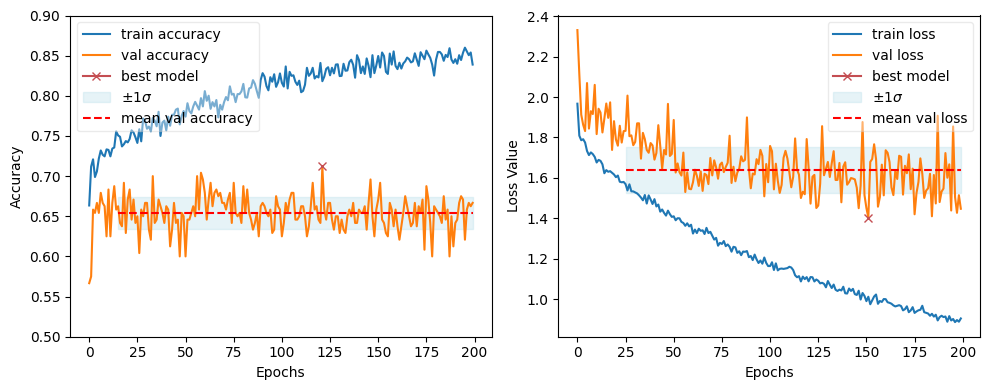

In [492]:
#Plot the learning curves of the VGG16 model
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot for Loss Value

# Plotting
axes[1].plot(VGG16B.history["loss"], label="train loss")
axes[1].plot(VGG16B.history["val_loss"], label="val loss")
axes[1].plot(np.argmin(VGG16B.history["val_loss"]),
             np.min(VGG16B.history["val_loss"]),
             marker="x", color="r", label="best model")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss Value")

# Fill between decision boundaries
x_fill_loss = np.arange(25, len(VGG16B.history["val_loss"]))
axes[1].fill_between(x_fill_loss, VGG16_boundary_low_loss, VGG16_boundary_high_loss, alpha=0.3, color='lightblue', label='$\pm 1 \sigma$')
axes[1].plot(x_fill_loss, [VGG16_mean_loss] * len(x_fill_loss), color='red', linestyle='--', label='mean val loss')
axes[1].legend(loc = "upper right" , frameon=True,  framealpha=0.4)

train_acc = np.insert(VGG16B.history["accuracy"], 0, 0.5)
val_acc = np.insert(VGG16B.history["val_accuracy"], 0, 0.5)


# Plot for Validation Accuracy  
axes[0].plot(VGG16B.history["accuracy"], label="train accuracy")
axes[0].plot(VGG16B.history["val_accuracy"], label="val accuracy")
axes[0].plot(np.argmax(VGG16B.history["val_accuracy"]),
             np.max(VGG16B.history["val_accuracy"]),
             marker="x", color="r", label="best model")

x_fill_acc = np.arange(15, len(VGG16B.history["val_accuracy"]))
axes[0].fill_between(x_fill_acc, VGG16_boundary_low_acc, VGG16_boundary_high_acc, alpha=0.3, color='lightblue', label='$\pm 1 \sigma$')
axes[0].plot(x_fill_acc, [VGG16_mean_acc] * len(x_fill_acc), color='red', linestyle='--', label='mean val accuracy')


axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend(loc = 'upper left', frameon=True,  framealpha=0.4)
axes[0].set_ylim([0.5, 0.9])  # Setting the y-axis to start from 0.5

plt.tight_layout()

plt.savefig("C:\\Users\\Johan\\Documents\\GY-Projekt\\Fotografier\\V5_VGG16BenchmarksV2.png", dpi=300)

plt.show()
print()

# InceptionV3

In [238]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the pretrained InceptionNet model without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False)


In [239]:
#Generates feature maps from the InceptionV3 model
x_train_predict = base_model.predict(x_trainRGB)
x_val_predict = base_model.predict(x_valRGB)

8/8 [==============================] - 14s 2s/step


In [240]:
#Create simple CNN architecture to add on top of InceptionV3
from tensorflow.keras.models import Sequential 
model = Sequential()
model.add(Flatten(input_shape=x_train_predict.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 51200)             0         
                                                                 
 dense_43 (Dense)            (None, 512)               26214912  
                                                                 
 dropout_38 (Dropout)        (None, 512)               0         
                                                                 
 dense_44 (Dense)            (None, 256)               131328    
                                                                 
 dropout_39 (Dropout)        (None, 256)               0         
                                                                 
 dense_45 (Dense)            (None, 32)                8224      
                                                                 
 dropout_40 (Dropout)        (None, 32)              

In [241]:
model.compile(optimizer=Adam(learning_rate = learn_rate),loss='binary_crossentropy', metrics=['accuracy'])

In [242]:
#Fit the neural network added on top of the VGG16 model
InceptionV3 = model.fit(x_train_predict, y_train,
          epochs=n_epochs,
          batch_size=batch_s,
          validation_data=(x_val_predict, y_val))

Epoch 1/200
250/250 [==============================] - 76s 298ms/step - loss: 0.7052 - accuracy: 0.7045 - val_loss: 0.7547 - val_accuracy: 0.5292
Epoch 2/200
250/250 [==============================] - 65s 262ms/step - loss: 0.5346 - accuracy: 0.7567 - val_loss: 0.6666 - val_accuracy: 0.5708
Epoch 3/200
250/250 [==============================] - 65s 258ms/step - loss: 0.4855 - accuracy: 0.7640 - val_loss: 0.6622 - val_accuracy: 0.6000
Epoch 4/200
250/250 [==============================] - 61s 245ms/step - loss: 0.4932 - accuracy: 0.7587 - val_loss: 0.6555 - val_accuracy: 0.6000
Epoch 5/200
250/250 [==============================] - 61s 246ms/step - loss: 0.4439 - accuracy: 0.7901 - val_loss: 0.6300 - val_accuracy: 0.6208
Epoch 6/200
250/250 [==============================] - 61s 245ms/step - loss: 0.3875 - accuracy: 0.8195 - val_loss: 0.6516 - val_accuracy: 0.6583
Epoch 7/200
250/250 [==============================] - 62s 248ms/step - loss: 0.3956 - accuracy: 0.8155 - val_loss: 0.6928 -

In [243]:
model_file_path = "C:\\Users\\Johan\\Documents\\Modeller\\INCEPTIONNET_pretr_ep50_imbs6_imep200.h5"

# Save the model
model.save(model_file_path)

history_file_path = "C:\\Users\\Johan\\Documents\\Modeller\\INCEPTIONNET_pretr_ep50_imbs6_imep200_HISTORY.h5"

with open(history_file_path, "wb") as file:
    pickle.dump(InceptionV3.history, file)

c:\Users\Johan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [288]:
#statistics (should be InceptionetV3, not VGG16).
VGG16_std_loss = np.std(InceptionV3.history["val_loss"][25:])
VGG16_mean_loss = np.mean(InceptionV3.history["val_loss"][25:])
VGG16_boundary_high_loss = VGG16_mean_loss + VGG16_std_loss
VGG16_boundary_low_loss = VGG16_mean_loss - VGG16_std_loss

VGG16_std_acc = np.std(InceptionV3.history["val_accuracy"][25:])
VGG16_mean_acc = np.mean(InceptionV3.history["val_accuracy"][25:])
VGG16_boundary_high_acc = VGG16_mean_acc + VGG16_std_acc
VGG16_boundary_low_acc = VGG16_mean_acc - VGG16_std_acc

print(VGG16_std_loss)
print(VGG16_std_acc)
print(VGG16_mean_loss)
print(VGG16_mean_acc)

1.378950309634625
0.02236962505814837
3.7904872281210764
0.6139761928149632


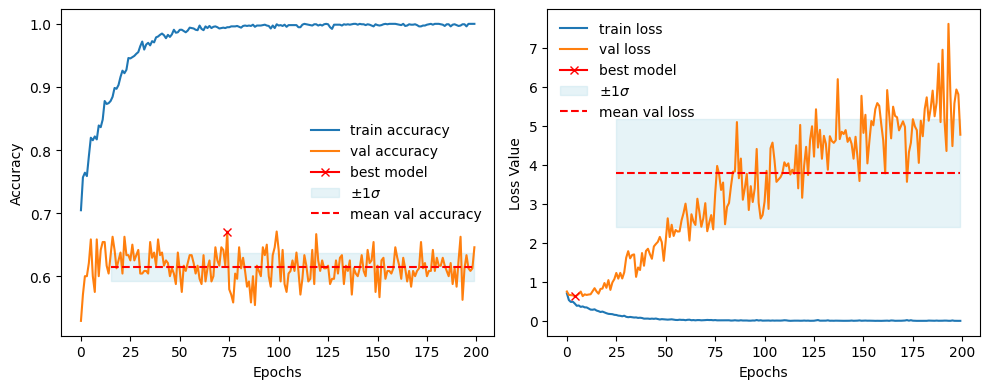

In [289]:
#Plot the learning curves from the InceptionV3 model
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting
axes[1].plot(InceptionV3.history["loss"], label="train loss")
axes[1].plot(InceptionV3.history["val_loss"], label="val loss")
axes[1].plot(np.argmin(InceptionV3.history["val_loss"]),
             np.min(InceptionV3.history["val_loss"]),
             marker="x", color="r", label="best model")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss Value")

# Fill between decision boundaries
x_fill_loss = np.arange(25, len(InceptionV3.history["val_loss"]))
axes[1].fill_between(x_fill_loss, VGG16_boundary_low_loss, VGG16_boundary_high_loss, alpha=0.3, color='lightblue', label='$\pm 1 \sigma$')
axes[1].plot(x_fill_loss, [VGG16_mean_loss] * len(x_fill_loss), color='red', linestyle='--', label='mean val loss')
axes[1].legend(frameon=False)


# Plot for Validation Accuracy
axes[0].plot(InceptionV3.history["accuracy"], label="train accuracy")
axes[0].plot(InceptionV3.history["val_accuracy"], label="val accuracy")
axes[0].plot(np.argmax(InceptionV3.history["val_accuracy"]),
             np.max(InceptionV3.history["val_accuracy"]),
             marker="x", color="r", label="best model")

x_fill_acc = np.arange(15, len(InceptionV3.history["val_accuracy"]))
axes[0].fill_between(x_fill_acc, VGG16_boundary_low_acc, VGG16_boundary_high_acc, alpha=0.3, color='lightblue', label='$\pm 1 \sigma$')
axes[0].plot(x_fill_acc, [VGG16_mean_acc] * len(x_fill_acc), color='red', linestyle='--', label='mean val accuracy')

axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend(frameon=False)

plt.tight_layout()

plt.savefig("C:\\Users\\Johan\\Documents\\GY-Projekt\\Fotografier\\InceptionV3_ep50_not_complete", dpi=300)

plt.show()
print()

In [293]:
InceptionV3.history["val_accuracy"]

[0.5291666388511658,
 0.5708333253860474,
 0.6000000238418579,
 0.6000000238418579,
 0.6208333373069763,
 0.6583333611488342,
 0.6000000238418579,
 0.574999988079071,
 0.6583333611488342,
 0.6000000238418579,
 0.6416666507720947,
 0.6541666388511658,
 0.6541666388511658,
 0.6166666746139526,
 0.6041666865348816,
 0.6333333253860474,
 0.6625000238418579,
 0.6416666507720947,
 0.612500011920929,
 0.625,
 0.637499988079071,
 0.6041666865348816,
 0.6625000238418579,
 0.6333333253860474,
 0.6333333253860474,
 0.625,
 0.6499999761581421,
 0.625,
 0.6333333253860474,
 0.6416666507720947,
 0.6041666865348816,
 0.6041666865348816,
 0.6083333492279053,
 0.6083333492279053,
 0.6041666865348816,
 0.6541666388511658,
 0.6291666626930237,
 0.637499988079071,
 0.6166666746139526,
 0.6583333611488342,
 0.6333333253860474,
 0.637499988079071,
 0.6166666746139526,
 0.625,
 0.6208333373069763,
 0.6000000238418579,
 0.612500011920929,
 0.6041666865348816,
 0.5874999761581421,
 0.637499988079071,
 0.608333

# AlexNet (Not Used in Updated Report)

In [222]:
#Define HyperParameters for AlexNet and LeNet
img_ch, img_width, img_height = 1, 224, 224
n_epochs = 200
batch_s = 3
n_base = 4
learn_rate = 1e-5

In [224]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

alex = AlexNet(img_ch, img_width, img_height)

alex.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learn_rate),
              metrics=['binary_accuracy'])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_200 (Conv2D)         (None, 224, 224, 4)       40        
                                                                 
 activation_188 (Activation  (None, 224, 224, 4)       0         
 )                                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 112, 112, 4)       0         
 g2D)                                                            
                                                                 
 conv2d_201 (Conv2D)         (None, 112, 112, 8)       296       
                                                                 
 activation_189 (Activation  (None, 112, 112, 8)       0         
 )                                                               
                                                     

In [ ]:
#Train the AlexNet model
alex_hist = alex.fit(x_train, y_train, batch_size = batch_s,
                  validation_data = (x_val, y_val),
                  epochs = n_epochs, verbose=1)

In [90]:
model_file_path = '/content/drive/My Drive/Rays/Projects/Saved_Models/AlexNet.h5'

# Save the model
alex.save(model_file_path)

history_file_path = '/content/drive/My Drive/Rays/Projects/Saved_Models/Saved_hist/AlexNet_hist.pickle'

with open(history_file_path, "wb") as file:
    pickle.dump(alex_hist.history, file)

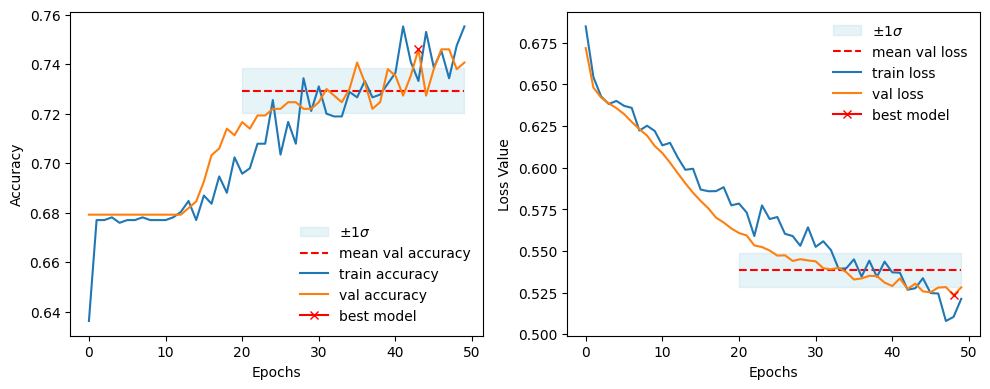

0.010183349229041731
0.008939799591165462
0.5382720212141673
0.7293226440747579


In [79]:
#Plot the AlexNet learning curves

plotting(alex_hist, "/content/drive/My Drive/Rays/Images_Graphs/Statistical/AlexNET_50epochs_stats_Transparent.png", True, 20, 20)

# LeNet (Not Used in Updated Report)

In [42]:
#Instantiate the LeNet Model
lenet = LeNet(img_ch, img_width, img_height)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 4)       40        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 4)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 8)       296       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 8)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 8)                

In [43]:
lenet.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learn_rate),
              metrics=['binary_accuracy'])

In [44]:
#Train the LeNet model
lenet_hist = lenet.fit(x_train, y_train, batch_size = batch_s,
                  validation_data = (x_val, y_val),
                  epochs = n_epochs, verbose=1)

Epoch 1/50
303/303 [==============================] - 28s 90ms/step - loss: 0.6903 - binary_accuracy: 0.6163 - val_loss: 0.6833 - val_binary_accuracy: 0.6791
Epoch 2/50
303/303 [==============================] - 27s 89ms/step - loss: 0.6663 - binary_accuracy: 0.6770 - val_loss: 0.6513 - val_binary_accuracy: 0.6791
Epoch 3/50
303/303 [==============================] - 29s 96ms/step - loss: 0.6402 - binary_accuracy: 0.6770 - val_loss: 0.6344 - val_binary_accuracy: 0.6791
Epoch 4/50
303/303 [==============================] - 27s 88ms/step - loss: 0.6304 - binary_accuracy: 0.6770 - val_loss: 0.6289 - val_binary_accuracy: 0.6791
Epoch 5/50
303/303 [==============================] - 25s 83ms/step - loss: 0.6266 - binary_accuracy: 0.6770 - val_loss: 0.6252 - val_binary_accuracy: 0.6791
Epoch 6/50
303/303 [==============================] - 27s 89ms/step - loss: 0.6229 - binary_accuracy: 0.6770 - val_loss: 0.6223 - val_binary_accuracy: 0.6791
Epoch 7/50
303/303 [==============================] 

In [88]:
model_file_path = '/content/drive/My Drive/Rays/Projects/Saved_Models/LeNet.h5'

# Save the model

lenet.save(model_file_path)

history_file_path = '/content/drive/My Drive/Rays/Projects/Saved_Models/Saved_hist/LeNet_hist.pickle'

with open(history_file_path, "wb") as file:
    pickle.dump(lenet_hist.history, file)

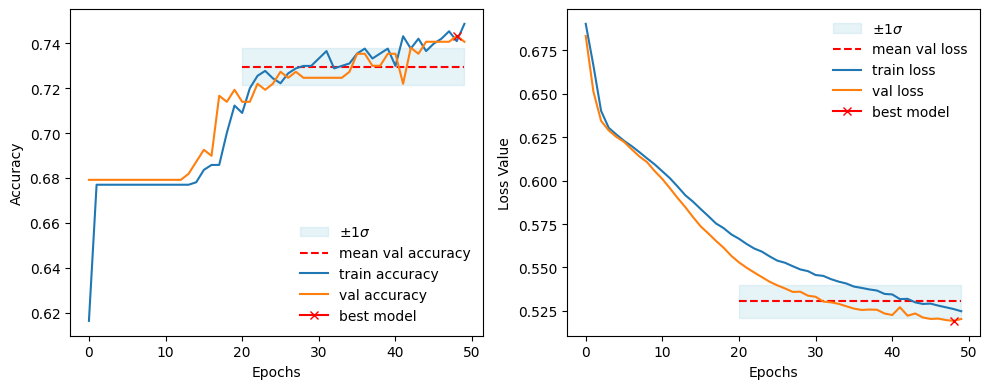

0.00942226352289513
0.008160799357512686
0.5304199854532877
0.7295900225639343


In [85]:
#Plot the LeNet learning curves
plotting(lenet_hist, "/content/drive/My Drive/Rays/Images_Graphs/Statistical/LeNET_50epochs_stats_Transparent.png", True, 20,20)

# Summarize Benchmarks of the different models by Creating a Violin Plot

Open Stored validation accuracies from the Random Forest Model

In [441]:
file_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\data\\Optimized_with_Balanced_dictionary.pkl"

# load  dictionary from the pickle file
with open(file_path, 'rb') as pickle_file:
    rf_auc_estimators_val = pickle.load(pickle_file)

RFValAccuracy = list(rf_auc_estimators_val.keys())

In [449]:
import tensorflow as tf
from tensorflow import keras

model_file_path = "C:\\Users\\Johan\\Documents\\Modeller\\INCEPTIONNET_pretr_ep50_imbs6_imep200.h5"
#model_file_path = "C:\\Users\\Johan\\Documents\\Modeller\\INCEPTIONNET_pretr_ep50_imbs6_imep200_HISTORY.h5"

# Load the model
model_INcep = keras.models.load_model(model_file_path)


In [452]:
import pickle
history_file_path = "C:\\Users\\Johan\\Documents\\Modeller\\INCEPTIONNET_pretr_ep50_imbs6_imep200_HISTORY.h5"

# Load the history
with open(history_file_path, "rb") as file:
    loaded_history = pickle.load(file)

Vizualise validation accuracies through a Violin Plot

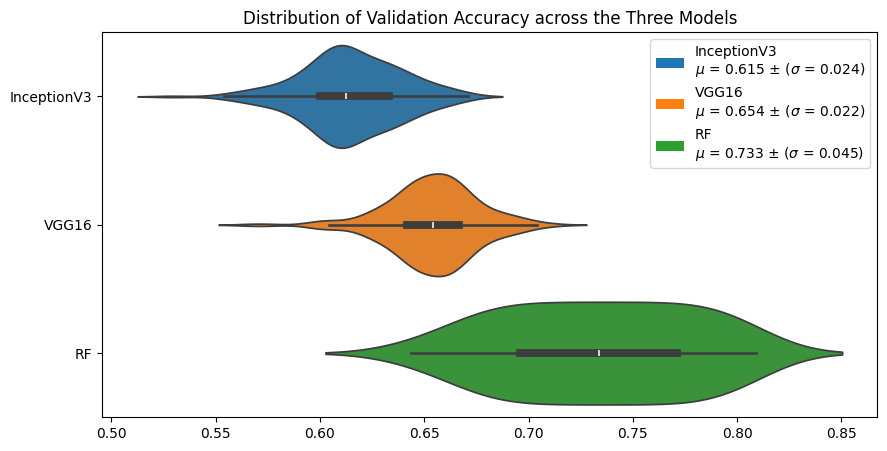

In [467]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data1 = loaded_history["val_accuracy"]
data2 = VGG16B.history["val_accuracy"]
data3 = RFValAccuracy

# Combine the data into a single list
combined_data = [data1, data2, data3]


custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"] 
custom_labels = ["InceptionV3", "VGG16", "Random Forest"] 
custom_labels2 = ["InceptionV3", "VGG16", "RF"]

std_dev_data1 = round(np.std(data1), ndigits=3)
mean_data1 = round(np.mean(data1), ndigits=3)

std_dev_data2 = round(np.std(data2), ndigits=3)
mean_data2 = round(np.mean(data2), ndigits=3)

std_dev_data3 = round(np.std(data3), ndigits=3)
mean_data3 = round(np.mean(data3), ndigits=3)


legend_labels = [f"{label}\n$\mu$ = {mean} $\pm$ ($\sigma$ = {std_dev})" for label, mean, std_dev in zip(custom_labels2, [mean_data1, mean_data2, mean_data3], [std_dev_data1, std_dev_data2, std_dev_data3])]

# Create a horizontal violin plot 
plt.figure(figsize=(10, 5))
sns.violinplot(data=combined_data, palette=custom_colors, orient="h")


plt.title("Distribution of Validation Accuracy across the Three Models")

# Set y-labels to custom model names
plt.yticks(range(len(custom_labels2)), custom_labels2)

# Customize the legend
legend_handles = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in custom_colors]
plt.legend(legend_handles, legend_labels, loc="upper right")
plt.savefig("C:\\Users\\Johan\\Documents\\GY-Projekt\\Fotografier\\ViolinPlotV2.png", dpi=300)


plt.show()


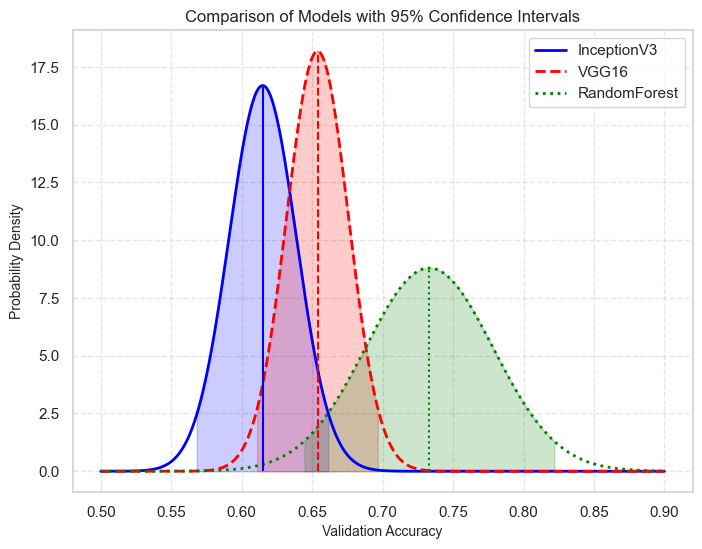

In [470]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns


data1 = loaded_history["val_accuracy"]
data2 = VGG16B.history["val_accuracy"]
data3 = RFValAccuracy

# Calculate means and standard deviations for each dataset
mean1, std1 = np.mean(data1), np.std(data1)
mean2, std2 = np.mean(data2), np.std(data2)
mean3, std3 = np.mean(data3), np.std(data3)

sns.set()
sns.set_style("white")
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 12

# Create x-values for Gaussian curves
x = np.linspace(0.5, 0.9, 1000)  # Adjust the range as needed

# Generate Gaussian curves
curve1 = norm.pdf(x, mean1, std1)
curve2 = norm.pdf(x, mean2, std2)
curve3 = norm.pdf(x, mean3, std3)

# Calculate confidence intervals (e.g., 95% CI)
ci_factor = 1.96
ci1 = ci_factor * std1
ci2 = ci_factor * std2
ci3 = ci_factor * std3

fig, ax = plt.subplots(figsize=(8, 6))

# plot the Gaussian curves
ax.plot(x, curve1, label='InceptionV3', color='blue', linewidth=2)
ax.plot(x, curve2, label='VGG16', color='red', linewidth=2, linestyle='--')
ax.plot(x, curve3, label='RandomForest', color='green', linewidth=2, linestyle=':')

# add vertical lines for the means
ax.vlines(mean1, 0, norm.pdf(mean1, mean1, std1), color='blue', linestyles='-', linewidth=1.5)
ax.vlines(mean2, 0, norm.pdf(mean2, mean2, std2), color='red', linestyles='--', linewidth=1.5)
ax.vlines(mean3, 0, norm.pdf(mean3, mean3, std3), color='green', linestyles=':', linewidth=1.5)

# shade the confidence intervals
ax.fill_between(x, 0, curve1, where=((x > mean1 - ci1) & (x < mean1 + ci1)), color='blue', alpha=0.2)
ax.fill_between(x, 0, curve2, where=((x > mean2 - ci2) & (x < mean2 + ci2)), color='red', alpha=0.2)
ax.fill_between(x, 0, curve3, where=((x > mean3 - ci3) & (x < mean3 + ci3)), color='green', alpha=0.2)

# customize appearance
ax.set_xlabel('Validation Accuracy')
ax.set_ylabel('Probability Density')
ax.set_title('Comparison of Models with 95% Confidence Intervals')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
for spine in ax.spines.values():
    spine.set_edgecolor('#D3D3D3')

plt.savefig("C:\\Users\\Johan\\Documents\\GY-Projekt\\Fotografier\\Gaussian_CI2V2.png", dpi=300)
plt.show()


In [473]:
import numpy as np
from scipy.stats import f_oneway

data1 = loaded_history["val_accuracy"]
data2 = VGG16B.history["val_accuracy"]
data3 = RFValAccuracy

# Perform the ANOVA test directly on the actual data
f_stat, p_value = f_oneway(data1, data2, data3)

# Output the results
print("F-statistic:", f_stat)
print("P-value:", p_value)


F-statistic: 431.53518777133223
P-value: 1.8548565756202336e-105


In [474]:
from scipy.stats import ttest_ind

data1 = loaded_history["val_accuracy"]
data2 = VGG16B.history["val_accuracy"]
data3 = RFValAccuracy

# Perform t-tests between pairs
t_stat_m1_m2, p_value_m1_m2 = ttest_ind(data1, data2)
t_stat_m2_m3, p_value_m2_m3 = ttest_ind(data2, data3)
t_stat_m1_m3, p_value_m1_m3 = ttest_ind(data1, data3)

print("Inception-VGG16:")
print("T-statistic:", t_stat_m1_m2)
print("P-value:", p_value_m1_m2)

print("\nVGG16-RF:")
print("T-statistic:", t_stat_m2_m3)
print("P-value:", p_value_m2_m3)

print("\nInception-RF:")
print("T-statistic:", t_stat_m1_m3)
print("P-value:", p_value_m1_m3)


Inception-VGG16:
T-statistic: -16.92839992713648
P-value: 8.27578196191001e-49

VGG16-RF:
T-statistic: -18.01824825354931
P-value: 3.3501704048534557e-47

Inception-RF:
T-statistic: -25.78022743511222
P-value: 1.289959563587222e-72


In [51]:
file_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\data\\Optimized_with_Balanced_dictionary.pkl"

# Load the dictionary from the pickle file
with open(file_path, 'rb') as pickle_file:
    rf_auc_estimators_val = pickle.load(pickle_file)

C:\Users\Johan\AppData\Local\Temp\ipykernel_17896\3582868167.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0)  # Remove padding around subplots


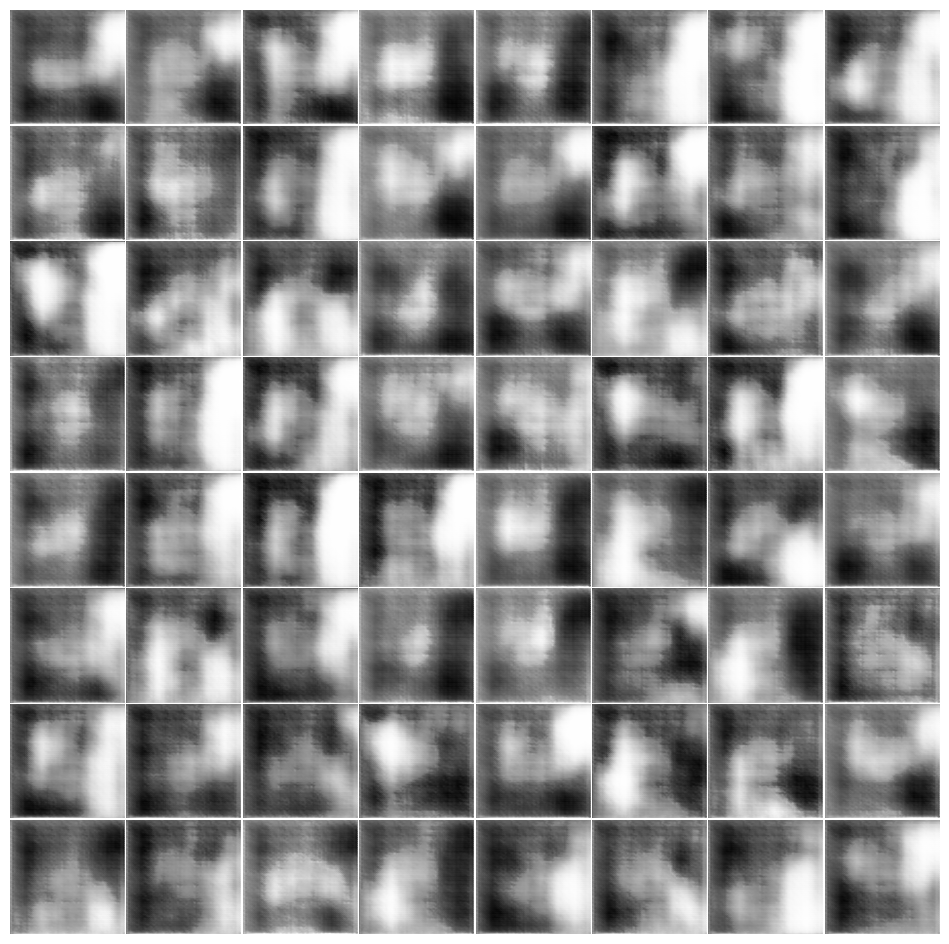

In [500]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Directory containing images
directory = "C:\\Users\\Johan\\Documents\\GY-Projekt\\GeneratedImages\\Malignant\\Improved_version"

fig, axes = plt.subplots(8, 8, figsize=(12, 12), gridspec_kw={'hspace': 0.01, 'wspace': 0.01})
axes = axes.ravel()  # Flatten the array of axes

image_files = os.listdir(directory)
for ax, image_file in zip(axes, image_files[:64]):  # Limit to first 64 images
    img_path = os.path.join(directory, image_file)
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    ax.imshow(img, cmap='gray')  # Display in grayscale
    ax.axis('off')

# Adjust layout
plt.tight_layout(pad=0)  # Remove padding around subplots
plt.savefig("C:\\Users\\Johan\\Documents\\GY-Projekt\\Fotografier\\GAN_samples.png", dpi=300)
plt.show()

